# Extract the graph that maximizes the sum of a given edge attribute and the coverage given a total distance

In [1]:
import numpy as np
import osmnx as ox
import networkx as nx
import igraph as ig

%matplotlib inline
np.random.seed(0)
ox.settings.use_cache = True
ox.__version__

'1.2.1'

In [2]:
place = "Los Angeles, California, USA"
weight = "length"

G = ox.graph_from_xml("./data/Los_Angeles.osm")
# Gp = ox.project_graph(G)


In [3]:
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [4]:
# see mean speed/time values by road type
nodes, edges = ox.graph_to_gdfs(G, nodes=True)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['motorway', 'motorway_link']",1318.5,105.5,45.0
"['motorway_link', 'motorway']",1184.6,101.5,42.0
"['motorway_link', 'primary']",100.0,96.3,3.7
"['motorway_link', 'residential']",120.0,96.3,4.5
"['motorway_link', 'secondary']",32.6,96.3,1.2
"['primary', 'motorway_link']",381.5,60.9,22.6
"['primary', 'secondary']",113.2,49.8,7.8
"['primary', 'trunk']",20.2,64.0,1.1
"['residential', 'primary_link']",84.5,60.9,5.0


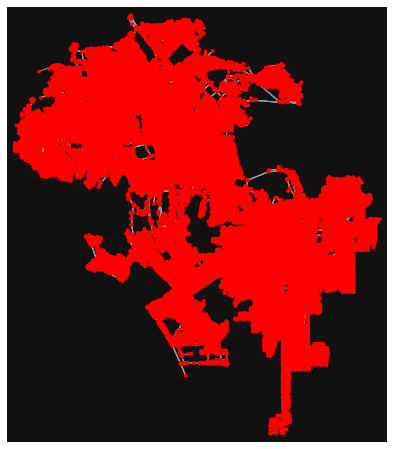

In [5]:
G = ox.graph_from_gdfs(nodes, edges, graph_attrs=G.graph)
fig, ax = ox.plot_graph(G, node_color="r")

In [6]:
# create networkx graph
osmids = list(G.nodes)
G = nx.relabel.convert_node_labels_to_integers(G)

# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(G.nodes, osmids)}
nx.set_node_attributes(G, osmid_values, "osmid")

In [7]:
# convert networkx graph to igraph
G_ig = ig.Graph(directed=True)
G_ig.add_vertices(G.nodes)
G_ig.add_edges(G.edges())
G_ig.vs["osmid"] = osmids
G_ig.es[weight] = list(nx.get_edge_attributes(G, weight).values())
G_ig